In [45]:
import pandas as pd

from sklearn.preprocessing import LabelEncoder
import nltk

In [7]:
df = pd.read_csv('../dataset/spam.csv' , encoding='latin-1')

In [8]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [9]:
df.shape

(5572, 5)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [11]:
df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

# Data Cleaning

In [13]:
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'] , inplace=True)

In [21]:
df.rename(columns={'v1':'target' , 'v2':'text'} , inplace=True)

In [25]:
df['target'].unique()

array(['ham', 'spam'], dtype=object)

In [27]:
encoder = LabelEncoder()

df['target'] = encoder.fit_transform(df['target'])

In [28]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [29]:
df.isnull().sum()

target    0
text      0
dtype: int64

In [30]:
df.duplicated().sum()

403

In [31]:
df = df.drop_duplicates(keep='first')

In [33]:
df.shape

(5169, 2)

# EDA

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
df['target'].value_counts()

0    4516
1     653
Name: target, dtype: int64

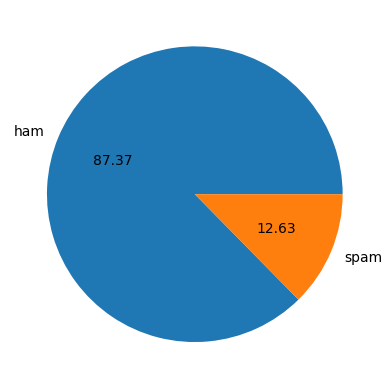

In [44]:
plt.pie(df['target'].value_counts() , labels=['ham' , 'spam']  , autopct="%0.2f")
plt.show()

spam is only 12% of the data hence data is imbalanced.

In [46]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\windows\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [51]:
# creating columns for number of characters words and sentence in each text
df['num_characters'] = df['text'].apply(lambda x : len(x))

C:\Users\windows\AppData\Local\Temp\ipykernel_7416\2284075443.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_characters'] = df['text'].apply(lambda x : len(x))


In [56]:
df['num_words'] = df['text'].apply(lambda x:len( nltk.word_tokenize(x)))

C:\Users\windows\AppData\Local\Temp\ipykernel_7416\240197938.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_words'] = df['text'].apply(lambda x:len( nltk.word_tokenize(x)))


In [59]:
df['num_sentence'] = df['text'].apply(lambda x :len( nltk.sent_tokenize(x)))

C:\Users\windows\AppData\Local\Temp\ipykernel_7416\39041603.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_sentence'] = df['text'].apply(lambda x :len( nltk.sent_tokenize(x)))


In [63]:
# for ham msgs
df[df['target'] == 0 ].describe()

,target,num_characters,num_words,num_sentence
count,4516.0,4516.000000,4516.000000,4516.000000
mean,0.0,70.459256,17.123782,1.820195
std,0.0,56.358207,13.493970,1.383657
min,0.0,2.000000,1.000000,1.000000
25%,0.0,34.000000,8.000000,1.000000
50%,0.0,52.000000,13.000000,1.000000
75%,0.0,90.000000,22.000000,2.000000
max,0.0,910.000000,220.000000,38.000000


In [62]:
df[df['target'] == 1 ].describe()

,target,num_characters,num_words,num_sentence
count,653.0,653.000000,653.000000,653.000000
mean,1.0,137.891271,27.667688,2.970904
std,0.0,30.137753,7.008418,1.488425
min,1.0,13.000000,2.000000,1.000000
25%,1.0,132.000000,25.000000,2.000000
50%,1.0,149.000000,29.000000,3.000000
75%,1.0,157.000000,32.000000,4.000000
max,1.0,224.000000,46.000000,9.000000


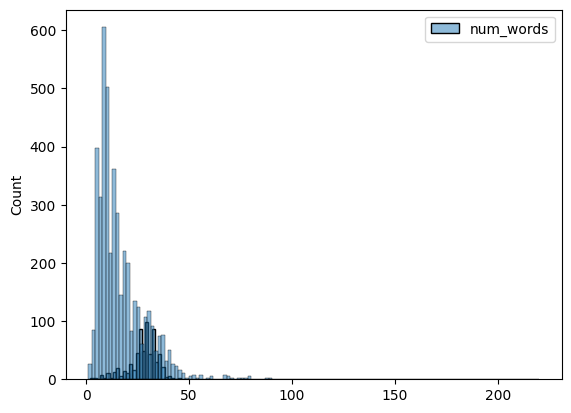

In [72]:
# plotting histogram for distribution

sns.histplot(df[df['target'] == 1][['num_words']] ) #spam msgs
sns.histplot(df[df['target'] == 0][['num_words']] , color = 'red' ) #ham msgs
plt.show()

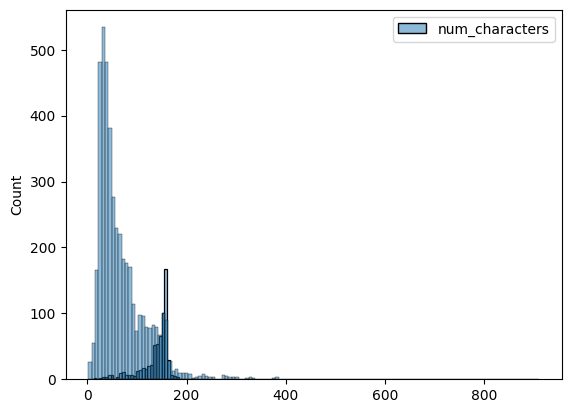

In [73]:
sns.histplot(df[df['target'] == 1][['num_characters']] ) #spam msgs
sns.histplot(df[df['target'] == 0][['num_characters']] , color = 'red' ) #ham msgs
plt.show()

C:\Users\windows\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


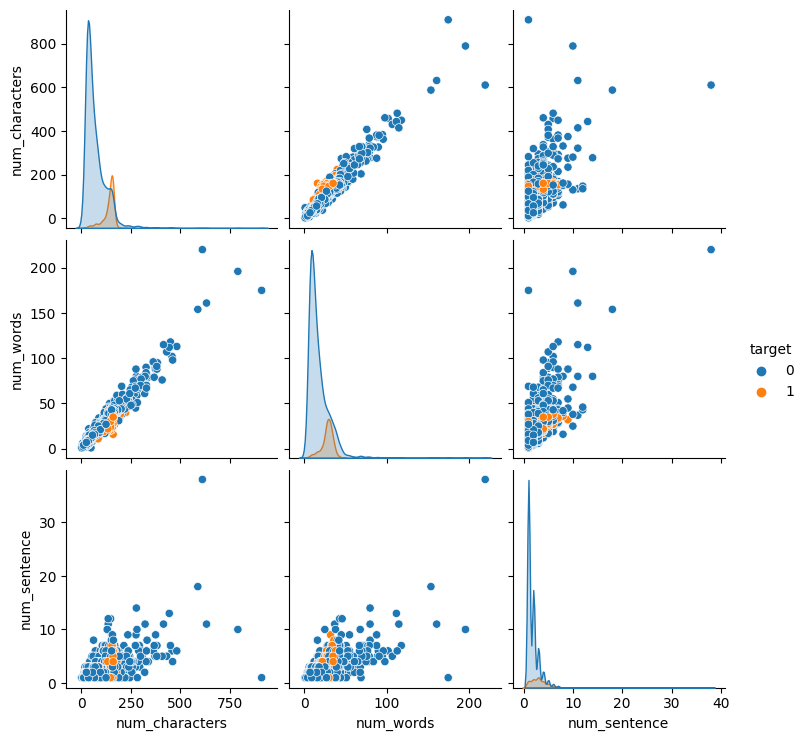

In [75]:
sns.pairplot(df , hue='target')
plt.show()

C:\Users\windows\AppData\Local\Temp\ipykernel_7416\1150832963.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr() , annot=True)


<Axes: >

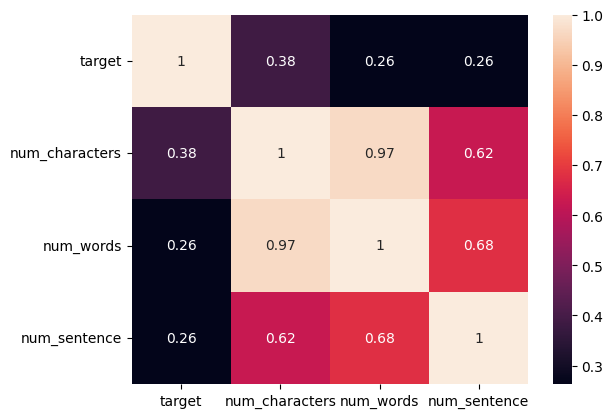

In [76]:
sns.heatmap(df.corr() , annot=True)

**num_char , num_word, num_sentence are strongly correlated to each** , so we cannot keep them all of the columns.
we will **keep num_char columns beacause it is strongly correlated to target column.**